In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.appName("best_book").getOrCreate()

In [4]:
dataPath = "hdfs://localhost:9000/user/nhom7/book/data/"
ratingsFilePath = dataPath + "BX-Book-Ratings.csv"
rating_df = spark.read.options(inferSchema="true", header="true", delimiter=';').csv(ratingsFilePath)

In [5]:
user_read_count = rating_df.groupBy('User-ID') \
                            .agg(F.count(rating_df['Book-Rating']).alias('Read-Count')) \
                            .cache()
                    
user_read_count.orderBy('Read-Count', ascending = False).show(10)

+-------+----------+
|User-ID|Read-Count|
+-------+----------+
|  11676|     13602|
| 198711|      7550|
| 153662|      6109|
|  98391|      5891|
|  35859|      5850|
| 212898|      4785|
| 278418|      4533|
|  76352|      3367|
| 110973|      3100|
| 235105|      3067|
+-------+----------+
only showing top 10 rows



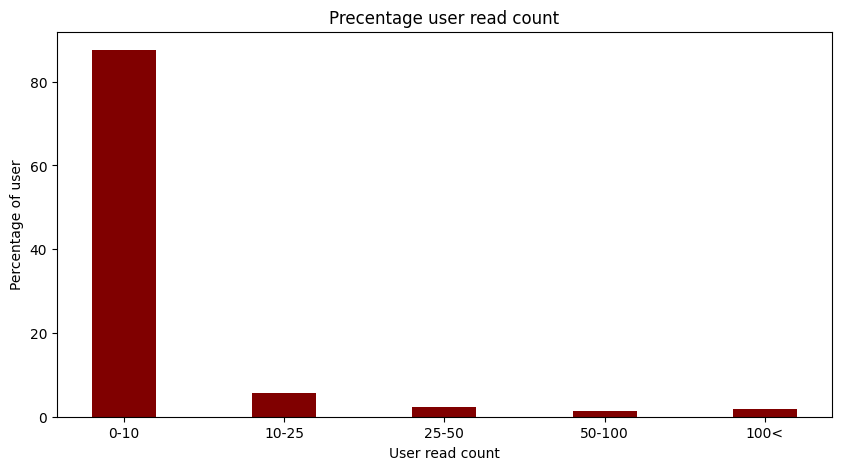

In [6]:
total_user = user_read_count.count()
read_count = [0, 10, 25, 50, 100]

number_user = []
for i in range(len(read_count)):
    userCount = 0
    
    if ((i + 1) == len(read_count)):
        userCount = user_read_count.filter(user_read_count['Read-Count'] > read_count[i]).count()
    else:
        userCount = user_read_count.filter((F.col('Read-Count') > read_count[i]) & (F.col('Read-Count') < read_count[i+1])).count()

    number_user.append(float(userCount / total_user * 100))

read_count_lable = []
for i in range(len(read_count)):
    if ((i + 1) == len(read_count)):
        read_count_lable.append(f"{read_count[i]}<")
    else:
        read_count_lable.append(f"{read_count[i]}-{read_count[i+1]}")


plt.figure(figsize = (10, 5))
plt.bar(read_count_lable, number_user, color ='maroon', width = 0.4)
 
plt.xlabel("User read count")
plt.ylabel("Percentage of user")
plt.title("Precentage user read count")
plt.show()

In [7]:
improved_rating = rating_df.join(user_read_count.filter(F.col('Read-Count') > 10), 'User-ID').select('ISBN', 'Book-Rating')

book_read_count = improved_rating.groupBy('ISBN') \
                            .agg(F.count(improved_rating['Book-Rating']).alias('Read-Count'), 
                                F.avg(improved_rating['Book-Rating']).alias('Average')) \
                            .cache()

book_read_count.orderBy('Read-Count', ascending = False).show(10)

+----------+----------+------------------+
|      ISBN|Read-Count|           Average|
+----------+----------+------------------+
|0971880107|      1387|0.6892573900504686|
|0316666343|       843| 3.792408066429419|
|0385504209|       620| 4.269354838709678|
|0060928336|       519|2.8073217726396917|
|0312195516|       480|3.7270833333333333|
|0142001740|       454|3.7687224669603525|
|067976402X|       447| 2.651006711409396|
|0679781587|       439|3.8086560364464694|
|0671027360|       435|3.3839080459770114|
|044021145X|       435|2.8229885057471265|
+----------+----------+------------------+
only showing top 10 rows



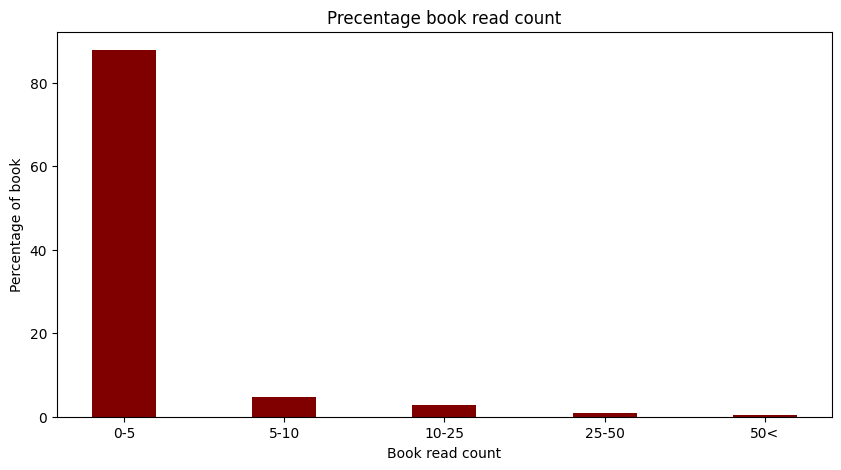

In [8]:
total_book = book_read_count.count()
read_count = [0, 5, 10, 25, 50]

number_book = []
for i in range(len(read_count)):
    bookCount = 0
    
    if ((i + 1) == len(read_count)):
        bookCount = book_read_count.filter(book_read_count['Read-Count'] > read_count[i]).count()
    else:
        bookCount = book_read_count.filter((F.col('Read-Count') > read_count[i]) & (F.col('Read-Count') < read_count[i+1])).count()

    number_book.append(float(bookCount / total_book * 100))

read_count_lable = []
for i in range(len(read_count)):
    if ((i + 1) == len(read_count)):
        read_count_lable.append(f"{read_count[i]}<")
    else:
        read_count_lable.append(f"{read_count[i]}-{read_count[i+1]}")


plt.figure(figsize = (10, 5))
plt.bar(read_count_lable, number_book, color ='maroon', width = 0.4)
 
plt.xlabel("Book read count")
plt.ylabel("Percentage of book")
plt.title("Precentage book read count")
plt.show()

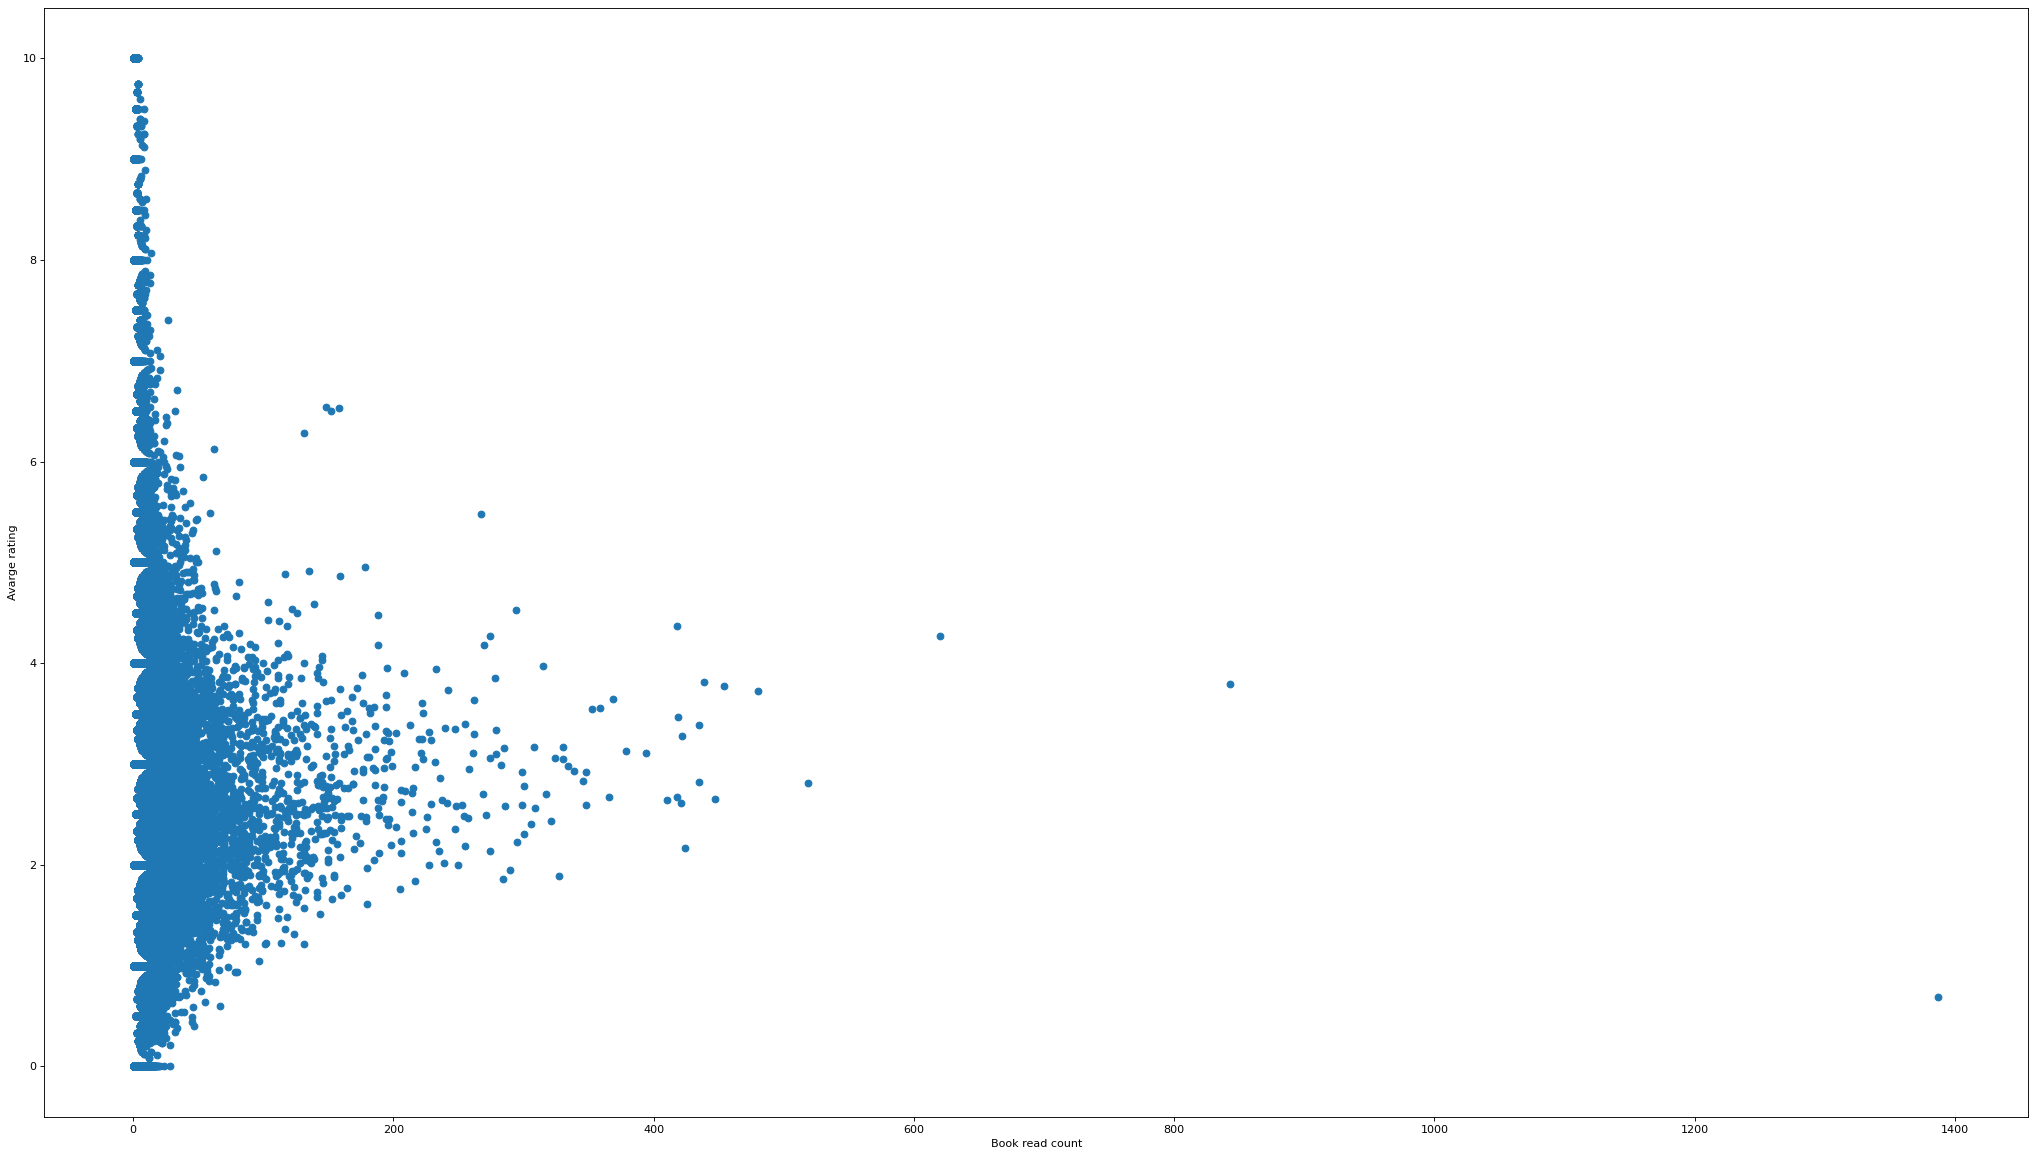

In [9]:
plt.figure(figsize=(32, 18), dpi=80)
plt.scatter(book_read_count.select('Read-Count').collect(), book_read_count.select('Average').collect())
plt.xlabel("Book read count")
plt.ylabel("Avarge rating")
plt.show()

In [10]:
best_book = book_read_count.filter((F.col('Read-Count') > 10) & (F.col('Average') > 6.5)) \
                            .orderBy('Average', ascending = False)

best_book.show(10)

+----------+----------+------------------+
|      ISBN|Read-Count|           Average|
+----------+----------+------------------+
|3522128001|        14| 8.071428571428571|
|0394823370|        11|               8.0|
|0836213122|        13| 7.846153846153846|
|8478886451|        13| 7.769230769230769|
|0684847817|        11| 7.454545454545454|
|0060256672|        27| 7.407407407407407|
|0452279623|        11| 7.363636363636363|
|0394800796|        13|7.3076923076923075|
|3596215226|        11|7.2727272727272725|
|1563890895|        11|7.2727272727272725|
+----------+----------+------------------+
only showing top 10 rows



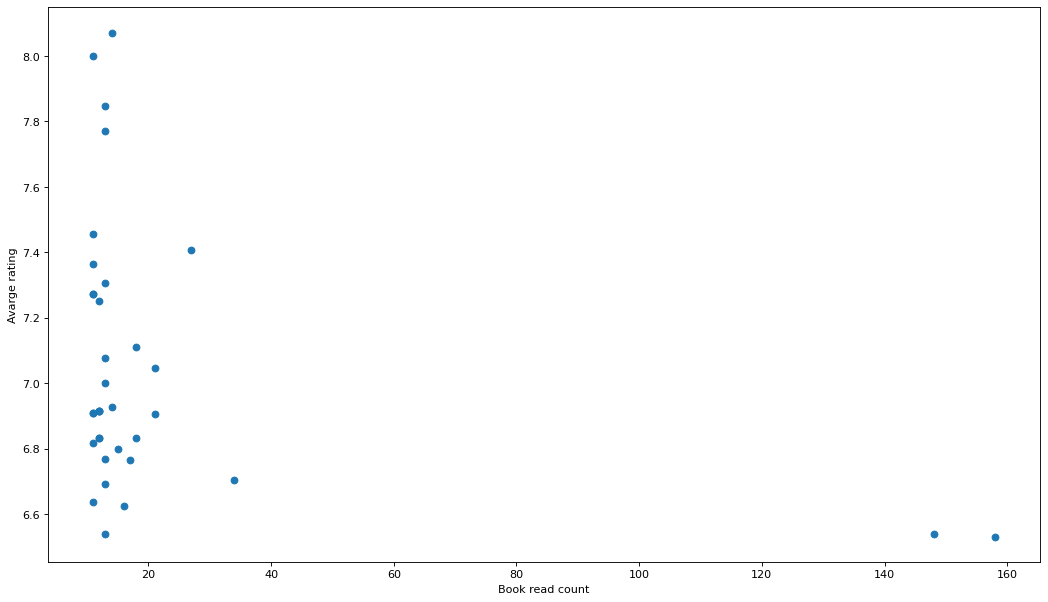

In [11]:
plt.figure(figsize=(16, 9), dpi=80)
plt.scatter(best_book.select('Read-Count').collect(), best_book.select('Average').collect())
plt.xlabel("Book read count")
plt.ylabel("Avarge rating")
plt.show()

In [12]:
best_book.toPandas().to_csv('../data/Best-Books.csv', sep=';')